In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict
import random
import operator
from sklearn.preprocessing import StandardScaler, Imputer
from scipy.spatial.distance import euclidean, cosine
from sklearn.model_selection import train_test_split

In [3]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor


/Users/colinshanahan/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [82]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

In [5]:
import warnings
warnings.simplefilter('ignore')

In [6]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [68]:
def rmse(yhat, y, round_to = None):
    ''' Return root mean squared error of a set of predictions '''
    err = np.sqrt(((yhat - y)**2).mean())
    if round_to:
        return round(err, round_to)
    else:
        return err

In [7]:
df = pd.read_csv('../data/data_for_model.csv', index_col='Season_Player')
df.drop([
    'Player', 'Season_Player.1', 'Season', 'Season_index'
], axis=1, inplace=True)

In [8]:
df['forward'] = (df['position'] != 'Defense')

In [9]:
df['signing_status'] = df.signing_status.apply(lambda x: 1 if 'UFA' else 0)

In [10]:
#These columns were causing problems
df.drop(['mean SH%', 'IPP', 'mean Faceoffs pct'], axis =1, inplace = True)

In [98]:
ycols = ['cap_hit', 'length', 'total_value', 'cap_pct', 'signing_year_cap']
xcols = ['forward', 'signing_age', 'signing_status'] + list(df.columns)[9:]
#xcols = ['forward', 'signing_age', 'mean Total Points/60', 'TOI/GP', 'Off. Zone Start %']

In [99]:
xcols

['forward',
 'signing_age',
 'signing_status',
 'GP',
 'TOI',
 'Goals',
 'Total Assists',
 'First Assists',
 'Second Assists',
 'Total Points',
 'Shots',
 'iCF',
 'iFF',
 'iSCF',
 'iHDCF',
 'Rush Attempts',
 'Rebounds Created',
 'PIM',
 'Total Penalties',
 'Minor',
 'Major',
 'Misconduct',
 'Penalties Drawn',
 'Giveaways',
 'Takeaways',
 'Hits',
 'Hits Taken',
 'Shots Blocked',
 'Faceoffs Won',
 'Faceoffs Lost',
 'sum GP',
 'sum TOI',
 'sum Goals',
 'sum Total Assists',
 'sum First Assists',
 'sum Second Assists',
 'sum Total Points',
 'sum Shots',
 'sum iCF',
 'sum iFF',
 'sum iSCF',
 'sum iHDCF',
 'sum Rush Attempts',
 'sum Rebounds Created',
 'sum PIM',
 'sum Total Penalties',
 'sum Minor',
 'sum Major',
 'sum Misconduct',
 'sum Penalties Drawn',
 'sum Giveaways',
 'sum Takeaways',
 'sum Hits',
 'sum Hits Taken',
 'sum Shots Blocked',
 'sum Faceoffs Won',
 'sum Faceoffs Lost',
 'mean GP',
 'mean TOI',
 'mean Goals',
 'mean Total Assists',
 'mean First Assists',
 'mean Second Assists

In [12]:
X, y = df[xcols], df[ycols]

In [517]:
X.shape

(1170, 197)

In [505]:
xcols[83], xcols[177], xcols[196]

('mean SH%', 'IPP', 'mean Faceoffs pct')

In [13]:
X.replace('-', 0, inplace=True)

X = X.apply(pd.to_numeric)

imp = Imputer(missing_values='NaN', strategy='mean', axis=0, verbose = 1)
X = imp.fit_transform(X)

In [635]:
X.shape

(1170, 5)

In [641]:
X_train, X_test, yp_train, yp_test, yl_train, yl_test, scap_train, scap_test = (
    train_test_split(X, y['cap_pct'], y['length'], y['signing_year_cap'], 
                     test_size = 0.15))

In [626]:
X_train.shape, yp_train.shape, yl_train.shape, scap_train.shape

((994, 4), (994,), (994,), (994,))

In [14]:
def predict_global_mean(yp_train, yp_test, yl_train, yl_test):
    pcmp = yp_train.mean()
    p_rmse = rmse(pcmp, yp_test, 2)
    print('RMSE pick mean cap_pct: {}%'.format(p_rmse))
    print('    translates to 2019 Cap Hit of: ${}'.format(p_rmse * 83000000 // 100))
    pcml = yl_train.mean()
    print('RMSE pick mean length: {} years'.format(rmse(pcml, yl_test, 1)))
    return pcmp, pcml

In [565]:
predict_global_mean(yp_train, yp_test, yl_train, yl_test)

RMSE pick mean cap_pct: 2.82%
    translates to 2019 Cap Hit of: 2340600.0
RMSE pick mean length: 1.7 years


(2.596197183098589, 2.2515090543259557)

In [15]:
reg_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, KNeighborsRegressor]

def run_regressor(split, m = GradientBoostingRegressor):
    '''
    Run a list of regression models for salary cap percent and contract length. 
    Predicted cap_pct is used as a feature for contract length.
    '''
    X_tr, X_te, yp_tr, yp_te, yl_tr, yl_te, scap_tr, scap_te = split 
    if m == LinearRegression:
        print(m.__name__)
        run_lin_regressor()
    else:
        print(m.__name__)
        model = m()
        model.fit(X_tr, yp_tr)
        cap_preds = model.predict(X_te)
        p_rmse = rmse(cap_preds, yp_te, 2)
        print('RMSE Cap_pct: {}%'.format(p_rmse))
        print('    translates to 2019 Cap Hit of: ${}'.format(p_rmse * 83000000 // 100))
        

        Xl_tr, Xl_te = X_tr.copy(), X_te.copy()
        Xl_tr = np.hstack((Xl_tr, model.predict(Xl_tr).reshape(-1,1)))
        Xl_te = np.hstack((Xl_te, cap_preds.reshape(-1,1)))

        l_model = m()
        l_model.fit(Xl_tr, yl_tr)
        length_preds = l_model.predict(Xl_te)
        l_rmse = rmse(length_preds, yl_te, 1)
        print('RMSE Length: {} years'.format(rmse(length_preds, yl_te, 1)))
        
        return p_rmse, l_rmse
    
def run_lin_regressor():
    X_tr, X_te, yp_tr, yp_te, yl_tr, yl_te, scap_tr, scap_te = split
    model = LinearRegression()
    model.fit(X_tr, yp_tr)
    cap_preds = model.predict(X_te)
    p_rmse = rmse(cap_preds, yp_te, 2)
    print('RMSE Cap_pct: {}%'.format(p_rmse))
    print('    translates to 2019 Cap Hit of: ${}'.format(p_rmse * 83000000 // 100))

    Xl_tr, Xl_te = X_tr.copy(), X_te.copy()
    Xl_tr = np.hstack((Xl_tr, model.predict(Xl_tr).reshape(-1,1), (Xl_tr[:,1]**2).reshape(-1,1)))
    Xl_te = np.hstack((Xl_te, cap_preds.reshape(-1,1), (Xl_te[:,1]**2).reshape(-1,1)))

    l_model = LinearRegression()
    l_model.fit(Xl_tr, yl_tr)
    length_preds = l_model.predict(Xl_te)
    l_rmse = rmse(length_preds, yl_te, 1)
    print('RMSE Length: {} years'.format(rmse(length_preds, yl_te, 1)))
    
    return p_rmse, l_rmse

In [717]:
split = (
    train_test_split(X, y['cap_pct'], y['length'], y['signing_year_cap'], 
                     test_size = 0.15))

X_train, X_test, yp_train, yp_test, yl_train, yl_test, scap_train, scap_test = split

predict_global_mean(yp_train, yp_test, yl_train, yl_test)
print()

for r in reg_list:
    run_regressor(split, r)
    print()

RMSE pick mean cap_pct: 2.75%
    translates to 2019 Cap Hit of: $2282500.0
RMSE pick mean length: 1.8 years

LinearRegression
RMSE Cap_pct: 1.12%
    translates to 2019 Cap Hit of: $929600.0
RMSE Length: 1.3 years

RandomForestRegressor
RMSE Cap_pct: 0.99%
    translates to 2019 Cap Hit of: $821700.0
RMSE Length: 1.1 years

GradientBoostingRegressor
RMSE Cap_pct: 0.81%
    translates to 2019 Cap Hit of: $672300.0
RMSE Length: 1.0 years

AdaBoostRegressor
RMSE Cap_pct: 1.19%
    translates to 2019 Cap Hit of: $987700.0
RMSE Length: 1.2 years

KNeighborsRegressor
RMSE Cap_pct: 1.31%
    translates to 2019 Cap Hit of: $1087300.0
RMSE Length: 1.3 years



In [718]:
print('GradientBoostingRegressor')
model = GradientBoostingRegressor(n_estimators = 100)
model.fit(X_train, yp_train)
cap_preds = model.predict(X_test)
p_rmse = rmse(cap_preds, yp_test, 2)
print('RMSE Cap_pct: {}%'.format(p_rmse))
print('    translates to 2019 Cap Hit of: ${}'.format(p_rmse * 83000000 // 100))


Xl_train, Xl_test = X_train.copy(), X_test.copy()
Xl_train = np.hstack((Xl_train, model.predict(Xl_train).reshape(-1,1), (Xl_train[:,1]**2).reshape(-1,1)))
Xl_test = np.hstack((Xl_test, cap_preds.reshape(-1,1), (Xl_test[:,1]**2).reshape(-1,1)))

print('LinearRegression')
l_model = LinearRegression()
l_model.fit(Xl_train, yl_train)
length_preds = l_model.predict(Xl_test)
print('RMSE Length: {} years'.format(rmse(length_preds, yl_test, 1)))

GradientBoostingRegressor
RMSE Cap_pct: 0.81%
    translates to 2019 Cap Hit of: $672300.0
LinearRegression
RMSE Length: 1.2 years


In [522]:
X2.shape

(994, 198)

In [418]:
reduced.shape

(994, 3)

In [421]:
len(xcols)

200

In [671]:
X2 = ss.fit_transform(X_train)

pca = PCA(n_components = 3).fit(X2)
reduced = np.dot(X2, pca.components_.T)

km = KMeans(n_clusters = 3)
clus = km.fit_transform(reduced)
X2 = np.hstack((X2, km.labels_.reshape(-1,1)))
reduced = np.hstack((reduced, km.labels_.reshape(-1,1)))
#forwards['cluster'] = fkm.labels_

clusts = []
cmeans = []
for i in range(km.n_clusters):
    clusts.append(X2[km.labels_ == i])
    cmeans.append(clusts[i].mean(axis=0))


X2df = pd.DataFrame(X2, columns = xcols + ['cluster'])

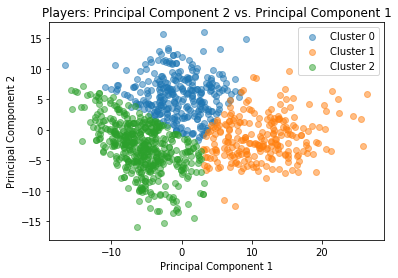

In [675]:
xax = 'Principal Component 1'
yax = 'Principal Component 2'
a = 0.5

for i in range(km.n_clusters):
    plt.scatter(reduced[reduced[:,3] == i][:,0],
              reduced[reduced[:,3] == i][:,1], 
              label = 'Cluster {}'.format(i), alpha = a)


plt.legend()
plt.xlabel(xax)
plt.ylabel(yax)
plt.title('Players: ' + yax + ' vs. ' + xax)

plt.show()

In [673]:
reduced.shape

(994, 4)

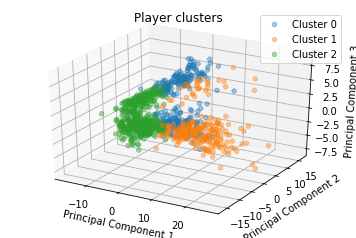

In [674]:
xax = 'Principal Component 1'
yax = 'Principal Component 2'
zax = 'Principal Component 3'
a=0.4

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

for i in range(km.n_clusters):
    ax.scatter(reduced[reduced[:,3] == i][:,0], 
               reduced[reduced[:,3] == i][:,1], 
                zs = reduced[reduced[:,3] == i][:,2], 
              label = 'Cluster {}'.format(i), alpha = a)

ax.set_xlabel(xax)
ax.set_ylabel(yax)
ax.set_zlabel(zax)
ax.set_title('Player clusters')

plt.legend()
plt.show()

In [710]:
X_train, X_test, yp_train, yp_test, yl_train, yl_test, scap_train, scap_test = (
    train_test_split(X, y['cap_pct'], y['length'], y['signing_year_cap'], 
                     test_size = 0.15))
split = X_train, X_test, yp_train, yp_test, yl_train, yl_test, scap_train, scap_test

X_train_s = ss.fit_transform(X_train)
X_test_s = ss.transform(X_test)

pca = PCA(n_components = 3).fit(X_train_s)
reduced = np.dot(X_train_s, pca.components_.T)
red_test = np.dot(X_test_s, pca.components_.T)

km = KMeans(n_clusters = 5)
clus = km.fit_transform(reduced)
X_train_s = np.hstack((X_train_s, km.labels_.reshape(-1,1)))
reduced = np.hstack((reduced, km.labels_.reshape(-1,1)))
#forwards['cluster'] = fkm.labels_
X_train = np.hstack((X_train, km.labels_.reshape(-1,1)))
X_test_s = np.hstack((X_test_s, km.predict(red_test).reshape(-1,1)))
X_test = np.hstack((X_test, km.predict(red_test).reshape(-1,1)))

clusts = []
cmeans = []
for i in range(km.n_clusters):
    clusts.append(X_train_s[km.labels_ == i])
    cmeans.append(clusts[i].mean(axis=0))

predict_global_mean(yp_train, yp_test, yl_train, yl_test)
print()

split = X_train_s, X_test_s, yp_train, yp_test, yl_train, yl_test, scap_train, scap_test

for i in range(km.n_clusters):
    print('cluster '+str(i) + '  -----------------')
    div_list = [X_train_s[X_train_s[:,-1] == i], 0, 
                yp_train[X_train_s[:,-1] == i], 0,
               yl_train[X_train_s[:,-1] == i], 0,
               scap_train[X_train_s[:,-1] == i], 0]
    for idx, div in enumerate(split):
        if idx % 2 != 0:
            div_list[idx] = div[X_test_s[:,-1] == i]
    for r in reg_list:
        run_regressor(div_list, r)
        print()

RMSE pick mean cap_pct: 2.52%
    translates to 2019 Cap Hit of: $2091600.0
RMSE pick mean length: 1.8 years

cluster 0  -----------------
LinearRegression
RMSE Cap_pct: 1.2%
    translates to 2019 Cap Hit of: $996000.0
RMSE Length: 1.3 years

RandomForestRegressor
RMSE Cap_pct: 1.43%
    translates to 2019 Cap Hit of: $1186900.0
RMSE Length: 1.6 years

GradientBoostingRegressor
RMSE Cap_pct: 1.57%
    translates to 2019 Cap Hit of: $1303100.0
RMSE Length: 1.7 years

AdaBoostRegressor
RMSE Cap_pct: 1.43%
    translates to 2019 Cap Hit of: $1186900.0
RMSE Length: 1.7 years

KNeighborsRegressor
RMSE Cap_pct: 2.06%
    translates to 2019 Cap Hit of: $1709800.0
RMSE Length: 2.2 years

cluster 1  -----------------
LinearRegression
RMSE Cap_pct: 1.2%
    translates to 2019 Cap Hit of: $996000.0
RMSE Length: 1.3 years

RandomForestRegressor
RMSE Cap_pct: 0.91%
    translates to 2019 Cap Hit of: $755300.0
RMSE Length: 1.2 years

GradientBoostingRegressor
RMSE Cap_pct: 0.67%
    translates to 2

In [607]:
from sklearn.linear_model import LassoCV, RidgeCV

In [608]:
las = LassoCV()

In [609]:
las.fit(X_train, yp_train)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [615]:
sum(abs(las.coef_) > 0.001)

4

In [ ]:
las.f

In [616]:
rid = RidgeCV()
rid.fit(X_train, yp_train)

RidgeCV(alphas=(0.1, 1.0, 10.0), cv=None, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False)

In [619]:
sum(abs(rid.coef_) > 0.1)

14

In [620]:
cap_preds = las.predict(X_test)
p_rmse = rmse(cap_preds, yp_test, 2)
print('RMSE Cap_pct: {}%'.format(p_rmse))
print('    translates to 2019 Cap Hit of: ${}'.format(p_rmse * 83000000 // 100))

RMSE Cap_pct: 1.14%
    translates to 2019 Cap Hit of: $946199.0


In [621]:
cap_preds = rid.predict(X_test)
p_rmse = rmse(cap_preds, yp_test, 2)
print('RMSE Cap_pct: {}%'.format(p_rmse))
print('    translates to 2019 Cap Hit of: ${}'.format(p_rmse * 83000000 // 100))

RMSE Cap_pct: 1.14%
    translates to 2019 Cap Hit of: $946199.0


In [799]:
split = (
    train_test_split(X, y['cap_pct'], y['length'], y['signing_year_cap'], 
                     test_size = 0.15))

X_train, X_test, yp_train, yp_test, yl_train, yl_test, scap_train, scap_test = split

predict_global_mean(yp_train, yp_test, yl_train, yl_test)
print()
print('MY MODEL')
sl_model = SalaryLengthPredictor()
sl_model.fit(X_train, yp_train, yl_train)
sl_model.score(X_test, yp_test, yl_test)
print()
print('SEPARATE MODELS')
s_mod = GradientBoostingRegressor()
s_mod.fit(X_train, yp_train)
l_mod = GradientBoostingRegressor()
l_mod.fit(X_train, yl_train)
s_rmse = rmse(s_mod.predict(X_test), yp_test, 2)
l_rmse = rmse(l_mod.predict(X_test), yl_test, 1)
print('RMSE Cap_pct: {}%'.format(s_rmse))
print('    translates to {} Cap Hit of: ${}'.format(2019, s_rmse * 83000000 // 100))
print('RMSE Length: {} years'.format(l_rmse))

RMSE pick mean cap_pct: 2.53%
    translates to 2019 Cap Hit of: $2099899.0
RMSE pick mean length: 1.7 years

MY MODEL
RMSE Cap_pct: 0.98%
    translates to 2019 Cap Hit of: $813400.0
RMSE Length: 1.1 years

SEPARATE MODELS
RMSE Cap_pct: 0.99%
    translates to 2019 Cap Hit of: $821700.0
RMSE Length: 1.1 years


In [795]:
from sklearn.model_selection import GridSearchCV, KFold, cross_validate

In [16]:
class SalaryLengthPredictor():
    def __init__(self, m = GradientBoostingRegressor, year = 2019):
        self.m = m
        
        self.scap = {
            2005: 39000000,
            2006: 44000000,
            2007: 50300000,
            2008: 56700000,
            2009: 56800000,
            2010: 59400000,
            2011: 64300000,
            2012: 60000000,
            2013: 64300000,
            2014: 69000000,
            2015: 71400000,
            2016: 73000000,
            2017: 75000000,
            2018: 79500000,
            2019: 83000000,
           }
        self.year = year
        self.year_cap = self.scap[year]
        pass
    
    def fit(self, X_train, yp_train, yl_train):
        '''
        Fit a model (default sklearn's GradientBoostingRegressor) for salary cap_pct
        and contract length
        '''
        self.X_train = X_train
        self.yp_train = yp_train
        self.yl_train = yl_train
        
        self.sal_model = self.m()
        self.sal_model.fit(X_train, yp_train)
        
        Xl_train = X_train.copy()
        Xl_train = np.hstack((Xl_train, self.sal_model.predict(Xl_train).reshape(-1,1)))

        self.len_model = self.m()
        self.len_model.fit(Xl_train, yl_train)
        pass
    
    def predict(self, X):
        '''
        Predict salary cap_pct and contract length
        '''
        self.cap_preds = self.sal_model.predict(X)
        Xl_test = X.copy()
        Xl_test = np.hstack((Xl_test, self.cap_preds.reshape(-1,1)))
        self.length_preds = self.len_model.predict(Xl_test)        
        
        return self.cap_preds, self.length_preds
    
    def score(self, X_test, yp_test, yl_test):
        '''
        Return RMSE for salary cap_pct, equivalent salary in $ for 2019 (default), 
        and RMSE for contract length
        '''
        cap_preds, length_preds = self.predict(X_test)
        self.p_rmse = self.rmse(cap_preds, yp_test, 2)
        self.cap_hit = self.p_rmse * self.year_cap // 100
        self.l_rmse = self.rmse(length_preds, yl_test, 1)
        print('RMSE Cap_pct: {}%'.format(self.p_rmse))
        print('    translates to {} Cap Hit of: ${}'.format(self.year, self.cap_hit))
        print('RMSE Length: {} years'.format(self.l_rmse))
        return self.p_rmse, self.cap_hit, self.l_rmse
    
    def rmse(self, yhat, y, round_to = None):
        ''' Return root mean squared error of a set of predictions '''
        err = np.sqrt(((yhat - y)**2).mean())
        if round_to:
            return round(err, round_to)
        else:
            return err

In [786]:
'''
The idea here was to borrow the methodology of NMF to run multi-target regression predictions 
back and forth until it converges. I'm not sure how to make it work so I'll come back to it later.
'''

class SalaryLengthPredictor_NMF():
    def __init__(self, n_iter = 50, m = GradientBoostingRegressor, year = 2019):
        self.m = m
        self.n_iter = n_iter
        self.scap = {
            2005: 39000000,
            2006: 44000000,
            2007: 50300000,
            2008: 56700000,
            2009: 56800000,
            2010: 59400000,
            2011: 64300000,
            2012: 60000000,
            2013: 64300000,
            2014: 69000000,
            2015: 71400000,
            2016: 73000000,
            2017: 75000000,
            2018: 79500000,
            2019: 83000000,
           }
        self.year = year
        self.year_cap = self.scap[year]
        pass
    
    def fit(self, X_train, yp_train, yl_train):
        '''
        Fit a model (default sklearn's GradientBoostingRegressor) for salary cap_pct
        and contract length
        '''
        self.X_train = X_train
        self.yp_train = yp_train
        self.yl_train = yl_train
        
        #initialize random columns for pred_cap_pct [:,-2], and pred_length [:,-1]
        cp = np.random.random(size = (X_train.shape[0],1)) * 15
        cl = np.random.random(size = (X_train.shape[0],1)) * 8
        
        for it in range(n_iter):
            self.X_train = np.hstack((X_train, cl))
        
            self.sal_model = self.m()
            self.sal_model.fit(X_train, yp_train)
            
            cp = self.sal_model.predict(X_train)
            X_train = np.delete(X_train, [X_train.shape[1]-1], 1)
            X_train = np.hstack((X_train, cp.reshape(-1,1)))

            self.len_model = self.m()
            self.len_model.fit(X_train, yl_train)
            cl = self.len_model.predict(X_train)
            X_train = np.delete(X_train, [X_train.shape[1]-1], 1)
            
        #store final pred_cap_pct, and pred_length  
        self.cp = cp
        self.cl = cl
        pass
    
    def predict(self, X):
        '''
        Predict salary cap_pct and contract length
        '''
        self.cap_preds = self.sal_model.predict(np.hstack((X, self.cl.reshape(-1,1)))
#         Xl_test = X.copy()
#         Xl_test = np.hstack((Xl_test, self.cap_preds.reshape(-1,1)))
        self.length_preds = self.len_model.predict(np.hstack((X, self.cp.reshape(-1,1))))        
        
        return self.cap_preds, self.length_preds
    
    def score(self, X_test, yp_test, yl_test):
        '''
        Return RMSE for salary cap_pct, equivalent salary in $ for 2019 (default), 
        and RMSE for contract length
        '''
        cap_preds, length_preds = self.predict(X_test)
        self.p_rmse = self.rmse(cap_preds, yp_test, 2)
        self.cap_hit = self.p_rmse * self.year_cap // 100
        self.l_rmse = self.rmse(length_preds, yl_test, 1)
        print('RMSE Cap_pct: {}%'.format(self.p_rmse))
        print('    translates to {} Cap Hit of: ${}'.format(self.year, self.cap_hit))
        print('RMSE Length: {} years'.format(self.l_rmse))
        return self.p_rmse, self.cap_hit, self.l_rmse
    
    def rmse(self, yhat, y, round_to = None):
        ''' Return root mean squared error of a set of predictions '''
        err = np.sqrt(((yhat - y)**2).mean())
        if round_to:
            return round(err, round_to)
        else:
            return err

SyntaxError: invalid syntax (<ipython-input-786-0d1cf846a1ae>, line 2)

In [772]:
a = np.array([[1,2,3], [4,5,6]])
a

array([[1, 2, 3],
       [4, 5, 6]])

In [781]:
c = a[:,-1]
b = np.delete(a, [0], 1)
print(a)
print(b)
print(c)

[[1 2 3]
 [4 5 6]]
[[2 3]
 [5 6]]
[3 6]


In [835]:
split = (
    train_test_split(X, y['cap_pct'], y['length'], y['signing_year_cap'], 
                     test_size = 0.15))

X_train, X_test, yp_train, yp_test, yl_train, yl_test, scap_train, scap_test = split

predict_global_mean(yp_train, yp_test, yl_train, yl_test)
print()

model = SalaryLengthPredictor()

RMSE pick mean cap_pct: 2.63%
    translates to 2019 Cap Hit of: $2182900.0
RMSE pick mean length: 1.7 years



In [836]:
model.fit(X_train, yp_train, yl_train)

In [837]:
preds = model.predict(X_test)

In [838]:
sum(model.cap_preds < 0), sum(model.length_preds < 0)

(0, 0)

In [839]:
model.cap_preds.shape, yp_test.shape

((176,), (176,))

In [840]:
model.score(X_test, yp_test, yl_test)

RMSE Cap_pct: 0.94%
    translates to 2019 Cap Hit of: $780200.0
RMSE Length: 1.0 years


(0.94, 780200.0, 1.0)

In [826]:
GradientBoostingRegressor()

params = {
    'learning_rate': [0.5, 0.1, 0.05], 
    'n_estimators': [50, 100, 500], 
    'max_depth': [2, 3, 5],
    'min_samples_split': [2, 3, 5],
    'subsample': [1, 0.5, 0.25], 
    'min_impurity_decrease': [0, 0.01, 0.1, 0.3], 
    'max_features': [None, 0.5, 'sqrt']
}

params_short = {
    'learning_rate': [0.05, 0.01], 
    'n_estimators': [10, 100, 250], 
    'max_depth': [2, 3],
    'min_samples_leaf': [1, 3], 
    'subsample': [1, 0.25], 
}

In [827]:
s_mo = GradientBoostingRegressor()
l_mo = GradientBoostingRegressor()
s_gs = GridSearchCV(s_mo, param_grid=params)
s_gs.fit(X_train, yp_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.5, 0.1, 0.05], 'n_estimators': [50, 100, 500], 'max_depth': [2, 3, 5], 'min_samples_split': [2, 3, 5], 'subsample': [1, 0.5, 0.25], 'min_impurity_decrease': [0, 0.01, 0.1, 0.3], 'max_features': [None, 0.5, 'sqrt']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [829]:
l_gs = GridSearchCV(l_mo, param_grid=params)
l_gs.fit(X_train, yl_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.5, 0.1, 0.05], 'n_estimators': [50, 100, 500], 'max_depth': [2, 3, 5], 'min_samples_split': [2, 3, 5], 'subsample': [1, 0.5, 0.25], 'min_impurity_decrease': [0, 0.01, 0.1, 0.3], 'max_features': [None, 0.5, 'sqrt']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [714]:
print('GradientBoostingRegressor')
model = GradientBoostingRegressor(n_estimators = 100)
model.fit(X_train, yp_train)
cap_preds = model.predict(X_test)
p_rmse = rmse(cap_preds, yp_test, 2)
print('RMSE Cap_pct: {}%'.format(p_rmse))
print('    translates to 2019 Cap Hit of: ${}'.format(p_rmse * 83000000 // 100))


Xl_train, Xl_test = X_train.copy(), X_test.copy()
Xl_preds = model.predict(Xl_train)
Xl_train = np.hstack((Xl_train, Xl_preds.reshape(-1,1), (Xl_preds**2).reshape(-1,1), (Xl_train[:,1]**2).reshape(-1,1)))
Xl_test = np.hstack((Xl_test, cap_preds.reshape(-1,1), (cap_preds**2).reshape(-1,1), (Xl_test[:,1]**2).reshape(-1,1)))

print('LinearRegression')
l_model = LinearRegression()
l_model.fit(Xl_train, yl_train)
length_preds = l_model.predict(Xl_test)
print('RMSE Length: {} years'.format(rmse(length_preds, yl_test, 1)))

GradientBoostingRegressor
RMSE Cap_pct: 0.98%
    translates to 2019 Cap Hit of: $813400.0
LinearRegression
RMSE Length: 1.1 years


In [820]:
gs.fit(X_train, yp_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.05, 0.01], 'n_estimators': [10, 100, 250], 'max_depth': [2, 3], 'min_samples_leaf': [1, 3], 'subsample': [1, 0.25]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [784]:
kw = {
    'learning_rate': 0.1,
    'n_estimators': 250, 
    'max_depth': 4, 
    'min_impurity_decrease': 0.05
}

kw2 = {
    'learning_rate': 0.05,
    'n_estimators': 500, 
    'max_depth': 3, 
    'min_impurity_decrease': 0.0
}

In [782]:
print('GradientBoostingRegressor')
model = GradientBoostingRegressor(**kw)
model.fit(X_train, yp_train)
cap_preds = model.predict(X_test)
p_rmse = rmse(cap_preds, yp_test, 2)
print('RMSE Cap_pct: {}%'.format(p_rmse))
print('    translates to 2019 Cap Hit of: ${}'.format(p_rmse * 83000000 // 100))

GradientBoostingRegressor
RMSE Cap_pct: 0.83%
    translates to 2019 Cap Hit of: $688900.0


In [785]:
print('GradientBoostingRegressor')
model = GradientBoostingRegressor(**kw2)
model.fit(X_train, yp_train)
cap_preds = model.predict(X_test)
p_rmse = rmse(cap_preds, yp_test, 2)
print('RMSE Cap_pct: {}%'.format(p_rmse))
print('    translates to 2019 Cap Hit of: ${}'.format(p_rmse * 83000000 // 100))

GradientBoostingRegressor
RMSE Cap_pct: 0.81%
    translates to 2019 Cap Hit of: $672300.0


In [830]:
estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),

In [832]:
kwt = {'alpha': 0.9, 'criterion': 'friedman_mse', 'init':None,
             'learning_rate':0.1, 'loss':'ls', 'max_depth':3, 'max_features':None,
             'max_leaf_nodes':None, 'min_impurity_decrease':0.0,
             'min_impurity_split':None, 'min_samples_leaf':1,
             'min_samples_split':2, 'min_weight_fraction_leaf':0.0,
             'n_estimators':100, 'presort':'auto', 'random_state':None,
             'subsample':1.0, 'verbose':0, 'warm_start':False}

In [833]:
gm = GradientBoostingRegressor(**kwt)

In [834]:
import rfpimp

In [854]:
X_train_df = pd.DataFrame(X_train, columns = xcols)
X_test_df = pd.DataFrame(X_test, columns = xcols)

sal_imp = rfpimp.importances(model.sal_model, X_test_df, yp_test)
X_test_df['pred_cap_pct'] = model.sal_model.predict(X_test)
len_imp = rfpimp.importances(model.len_model, X_test_df, yl_test)

In [855]:
sal_imp

,Importance
Feature,
TOI/GP,0.083884
Total Points,0.074436
TOI,0.039254
3yr TOI/GP,0.029348
iCF,0.016902
mean Total Points,0.015494
signing_age,0.014185
Total Assists,0.006414
sum Takeaways,0.006384


In [856]:
len_imp

,Importance
Feature,
pred_cap_pct,1.192037
signing_age,0.032302
GF% Rel,0.015758
sum Hits Taken,0.013761
mean GP,0.010093
3yr Def. Zone Starts/60,0.008656
Hits Taken,0.008456
Shots/60,0.007334
3yr SF% Rel,0.007307


In [849]:
rfpimp.importances(model.sal_model, X_train_df, yp_train)

,Importance
Feature,
TOI/GP,0.082342
Total Points,0.082056
TOI,0.046952
mean Total Points,0.026065
Total Assists,0.021713
3yr TOI/GP,0.017159
signing_age,0.013035
iCF,0.012647
sum Total Points,0.008180


In [850]:
X_train_df['pred_cap_pct'] = model.sal_model.predict(X_train)
rfpimp.importances(model.len_model, X_train_df, yl_train)

,Importance
Feature,
pred_cap_pct,1.240697
signing_age,0.056229
Hits Taken,0.023402
Shots Blocked,0.016592
sum Shots,0.016430
3yr LDCA/60 Rel,0.010425
3yr SF% Rel,0.007054
3yr CF% Rel,0.005517
LDGA/60 Rel,0.005265


In [17]:
df.shape

(1170, 204)

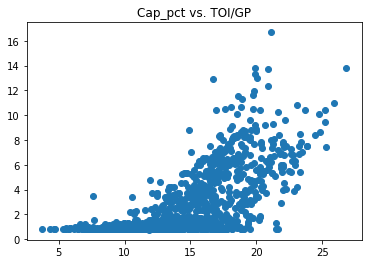

In [19]:
plt.scatter(df['TOI/GP'], df['cap_pct'])
plt.title('Cap_pct vs. TOI/GP')
plt.show()

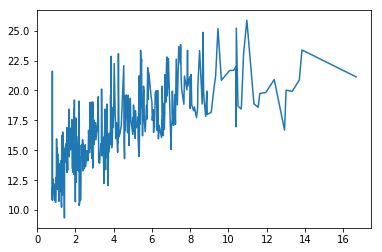

In [24]:
plt.plot(df.groupby('cap_pct')['TOI/GP'].mean())
plt.show()

In [58]:
cutdf = df.copy()
toibins = np.arange(1,12) * 2.5
cutdf['TOIbin'] = pd.cut(df['TOI/GP'], toibins)
means = cutdf.groupby('TOIbin')['cap_pct'].mean()

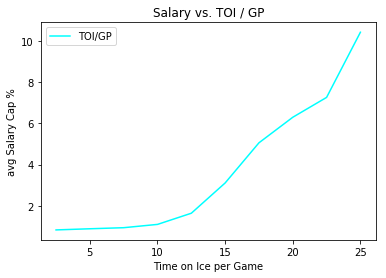

In [63]:
plt.plot(toibins[:-1], means, color = 'cyan', label = 'TOI/GP')
plt.xlabel('Time on Ice per Game')
plt.ylabel('avg Salary Cap %')
plt.title('Salary vs. TOI / GP')
plt.legend()
plt.show()

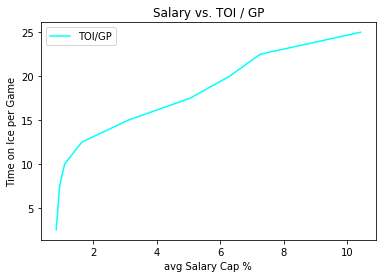

In [62]:
plt.plot(means, toibins[:-1], color = 'cyan', label = 'TOI/GP')
plt.ylabel('Time on Ice per Game')
plt.xlabel('avg Salary Cap %')
plt.title('Salary vs. TOI / GP')
plt.legend()
plt.show()

In [49]:
means

TOIbin
(2.5, 5.0]       0.832500
(5.0, 7.5]       0.888108
(7.5, 10.0]      0.940082
(10.0, 12.5]     1.099641
(12.5, 15.0]     1.641133
(15.0, 17.5]     3.107593
(17.5, 20.0]     5.054012
(20.0, 22.5]     6.291692
(22.5, 25.0]     7.254545
(25.0, 27.5]    10.412000
Name: cap_pct, dtype: float64

In [64]:
df['cap_pct'].max(), df['cap_pct'].min()

(16.67, 0.77)

In [88]:
pctbins = np.linspace(0.75, 16.75, 15)
cutdf = df.copy()
#toibins = np.arange(1,12) * 2.5
cutdf['pctbin'] = pd.cut(df['cap_pct'], pctbins)
means = cutdf.groupby('pctbin')[['TOI/GP', 'Total Points', 'iCF', 'signing_age']].mean()

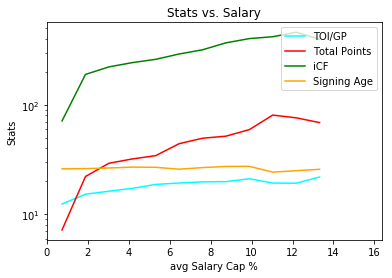

In [89]:
plt.plot(pctbins[:-1], means['TOI/GP'], color = 'cyan', label = 'TOI/GP')
plt.plot(pctbins[:-1], means['Total Points'], color = 'r', label = 'Total Points')
plt.plot(pctbins[:-1], means['iCF'], color = 'g', label = 'iCF')
plt.plot(pctbins[:-1], means['signing_age'], color = 'orange', label = 'Signing Age')
plt.ylabel('Stats')
plt.xlabel('avg Salary Cap %')
plt.title('Stats vs. Salary')
plt.legend()
plt.semilogy()
plt.show()

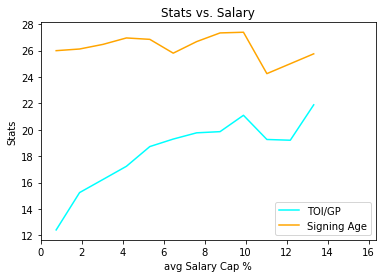

In [90]:
plt.plot(pctbins[:-1], means['TOI/GP'], color = 'cyan', label = 'TOI/GP')
#plt.plot(pctbins[:-1], means['Total Points'], color = 'r', label = 'Total Points')
#plt.plot(pctbins[:-1], means['iCF'], color = 'g', label = 'iCF')
plt.plot(pctbins[:-1], means['signing_age'], color = 'orange', label = 'Signing Age')
plt.ylabel('Stats')
plt.xlabel('avg Salary Cap %')
plt.title('Stats vs. Salary')
plt.legend()
#plt.semilogy()
plt.show()

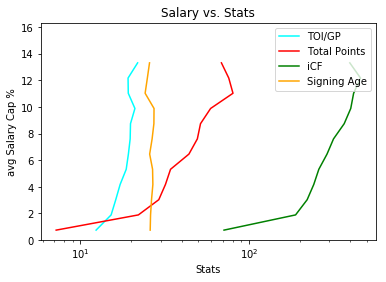

In [91]:
plt.plot(means['TOI/GP'], pctbins[:-1], color = 'cyan', label = 'TOI/GP')
plt.plot(means['Total Points'], pctbins[:-1], color = 'r', label = 'Total Points')
plt.plot(means['iCF'], pctbins[:-1], color = 'g', label = 'iCF')
plt.plot(means['signing_age'], pctbins[:-1], color = 'orange', label = 'Signing Age')
plt.xlabel('Stats')
plt.ylabel('avg Salary Cap %')
plt.title('Salary vs. Stats')
plt.legend()
plt.semilogx()
plt.show()

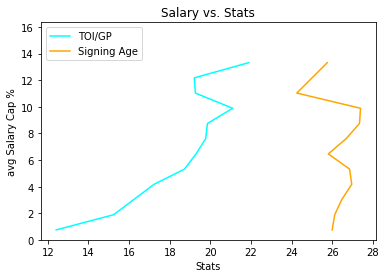

In [92]:
plt.plot(means['TOI/GP'], pctbins[:-1], color = 'cyan', label = 'TOI/GP')
#plt.plot(means['Total Points'], pctbins[:-1], color = 'r', label = 'Total Points')
#plt.plot(means['iCF'], pctbins[:-1], color = 'g', label = 'iCF')
plt.plot(means['signing_age'], pctbins[:-1], color = 'orange', label = 'Signing Age')
plt.xlabel('Stats')
plt.ylabel('avg Salary Cap %')
plt.title('Salary vs. Stats')
plt.legend()
#plt.semilogx()
plt.show()

In [94]:
import io

In [96]:
out = io.StringIO()
out = model.sal_model.export_graphviz(clf, out_file=out)

NameError: name 'model' is not defined